In [59]:
import_fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/data/imports/results.csv"
profile_fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/data/imports/combined_weighted_generator_timeseries.nc"
config_fn = "../../config/config.yaml"
gadm_fn = "gadm41_ARG.gpkg"
glc_fn = "/home/fneum/bwss/playgrounds/pr/pypsa-eur/resources/Copernicus_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif"
wdpa_fn = "/home/fneum/bwss/playgrounds/pr/pypsa-eur/resources/WDPA_Oct2023.gpkg"
matplotlibrc_fn = "../pypsa-eur/matplotlibrc"

In [60]:
import pandas as pd
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import country_converter as coco
cc = coco.CountryConverter()
import yaml
from atlite.gis import ExclusionContainer, shape_availability
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask

AREA_CRS = "ESRI:54009"

plt.style.use(["bmh", matplotlibrc_fn])

In [61]:
ds = xr.open_dataset(profile_fn)

In [62]:
with open(config_fn, "r") as f:
    config = yaml.safe_load(f)

tech_colors = config["plotting"]["tech_colors"]

In [63]:
NICE_NAMES = {
    "pipeline-h2": r"H$_2$ (pipeline)",
    "shipping-lh2": "H$_2$ (ship)",
    "shipping-ftfuel": "Fischer-Tropsch",
    "shipping-meoh": "methanol",
    "shipping-lch4": "methane",
    "shipping-lnh3": "ammonia",
    "shipping-steel": "steel",
}

In [64]:
COLORS = {
    "wind": tech_colors["onwind"],
    "solar": tech_colors["solar"],
    "storage": tech_colors["battery"],
    "electrolysis": tech_colors["H2 Electrolysis"],
    "direct air capture": tech_colors["DAC"],
    "hydrogen conversion": tech_colors["Fischer-Tropsch"],
    "iron ore": "#4e4f55",
    "direct iron reduction": tech_colors["steel"],
    "electric arc furnace": "#8795a8",
    "evaporation/liquefaction": "#8487e8",
    "transport": "#f7a572",
}

In [65]:
def rename(s):
    if "solar" in s:
        return "solar"
    if "wind" in s:
        return "wind"
    if "storage" in s or "inverter" in s:
        return "storage"
    if "transport" in s or "shipping fuel"  in s or "dry bulk" in s or "pipeline" in s:
        return "transport"
    if "evaporation" in s or "liquefaction" in s or "compress" in s:
        return "evaporation/liquefaction"
    if "direct air capture" in s or "heat pump" in s:
        return "direct air capture"
    if s in ["Haber-Bosch (exp)", "Fischer-Tropsch (exp)", "methanolisation (exp)", "methanation (exp)"]:
        return "hydrogen conversion"
    if "iron ore" in s:
        return "iron ore"
    if "direct iron reduction" in s:
        return "direct iron reduction"
    if "electric arc furnace" in s:
        return "electric arc furnace"
    return s.replace(" (exp)", "")


In [66]:
profile = ds.sel(exporter='MA', importer='EUE').p_max_pu.to_pandas().T
profile.rename(columns={"onwind": "wind", "solar-utility": "solar"}, inplace=True)

technology,offwind,wind,solar
snapshot,,,
2013-01-01,0.432972,0.165917,0.0


In [67]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).set_index("iso_a3")
world.drop("ATA", inplace=True)

/tmp/ipykernel_662147/2959749056.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).set_index("iso_a3")


,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,889953.0,Oceania,Fiji,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."


In [68]:
eu_countries = cc.convert(config["countries"], src="iso2", to="iso3")
europe = world.loc[eu_countries]

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
ALB,2854191.0,Europe,Albania,15279,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."


In [69]:
gadm = gpd.read_file(gadm_fn, layer="ADM_ADM_1").set_index("NAME_1")
shape = gadm.to_crs(AREA_CRS).loc[["Buenos Aires"]].geometry

In [70]:
df = pd.read_csv(import_fn, sep=";")

,scenario,year,wacc,esc,exporter,importer,category,subcategory,value
0,default,2030,pypsa-eur-sec,hvdc-to-elec,CN-West,EUE,general,Total system cost,4.598649e+10


In [71]:
import_costs = df.query("subcategory == 'Cost per MWh delivered' and esc == 'shipping-meoh'").groupby("exporter").value.min()
import_costs.index = cc.convert(import_costs.index.str.split("-").str[0], to="ISO3")
import_costs.drop("RUS", inplace=True)
import_costs.head(1)

ARG    94.394223
Name: value, dtype: float64

In [72]:
def get_cost_composition(df, country, escs, production):
    query_str = "category == 'cost' and exporter == @country and esc in @escs"
    composition = df.query(query_str).groupby(["esc", "subcategory", "importer"]).value.min()

    minimal = {}
    for name, group in composition.groupby("esc"):
        c = group.unstack("importer").droplevel("esc")
        minimal[name] = c[c.sum().idxmin()]
    composition = pd.concat(minimal, axis=1)

    composition = composition.groupby(rename).sum().div(production)

    composition = composition.where(composition > 0.01).dropna(how='all')

    sort_by = composition.sum().sort_values(ascending=True).index
    selection = pd.Index(COLORS.keys()).intersection(composition.index)
    composition = composition.loc[selection, sort_by].rename(columns=NICE_NAMES)
    return composition


In [73]:
composition_arg = get_cost_composition(
    df,
    "AR",
    ["shipping-lh2", "shipping-ftfuel", "shipping-meoh", "shipping-lch4", "shipping-lnh3"],
    500e6
)

In [74]:
composition_sau = get_cost_composition(
    df,
    "SA",
    ["pipeline-h2", "shipping-lh2"],
    500e6
)

In [75]:
composition_aus = get_cost_composition(
    df,
    "AU",
    ["shipping-steel"],
    100e6
)

In [76]:
# add to legend
composition_arg.loc["iron ore"] = pd.NA
composition_arg.loc["direct iron reduction"] = pd.NA
composition_arg.loc["electric arc furnace"] = pd.NA

In [77]:
def add_land_eligibility_example(ax):

    excluder = ExclusionContainer(crs=AREA_CRS, res=200)
    excluder.add_raster(glc_fn, codes=[20, 30, 40, 60, 100], invert=True)
    excluder.add_raster(glc_fn, codes=[50], buffer=1500)
    wdpa = gpd.read_file(
        wdpa_fn,
        bbox=shape.to_crs(4326).geometry,
        layer="WDPA_Oct2023_Public_shp-polygons",
    ).to_crs(AREA_CRS)
    excluder.add_geometry(wdpa.geometry, buffer=1000)

    band, transform = shape_availability(shape, excluder)
    mask = ~geometry_mask(
        [shape.geometry.values[0]],
        transform=transform,
        invert=False,
        out_shape=band.shape
    )
    masked_band = np.where(mask, ~band, np.nan)

    shape.plot(ax=ax, color="none", edgecolor='k', linewidth=1)
    show(masked_band, transform=transform, cmap="Purples", ax=ax)
    ax.set_axis_off()

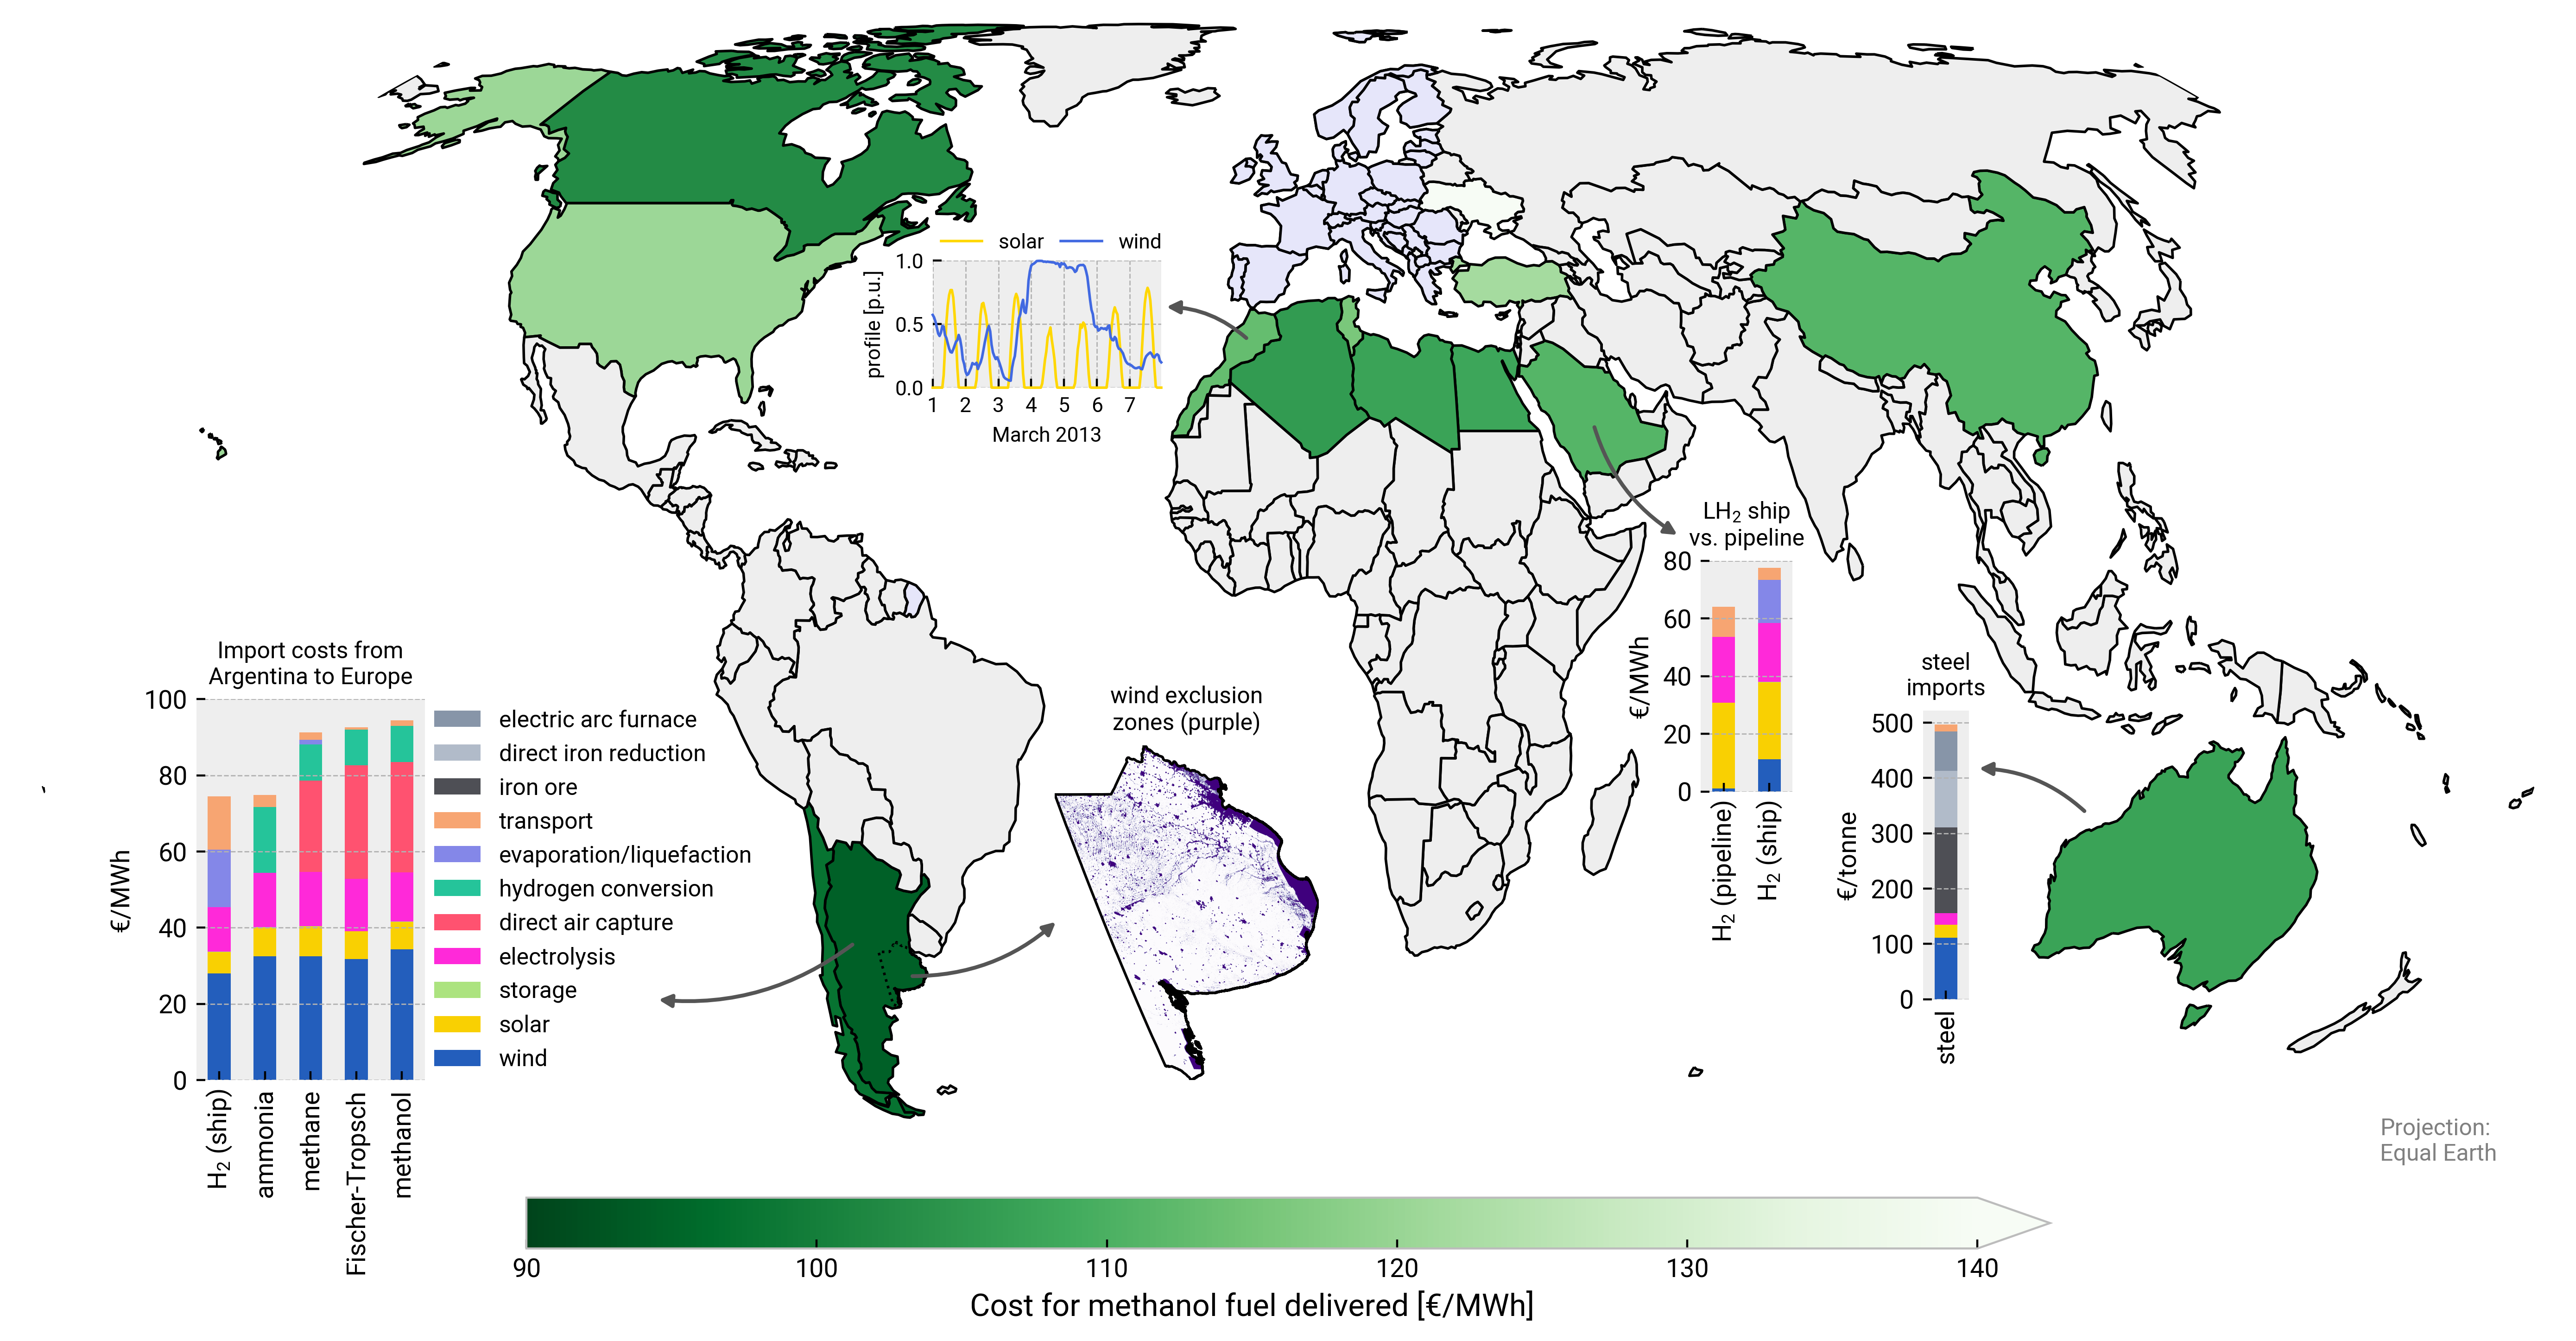

In [80]:
crs = ccrs.EqualEarth()

fig, ax = plt.subplots(figsize=(14,14), subplot_kw={"projection": crs})

# main axis: choropleth layer

world.to_crs(crs).plot(
    column=import_costs.reindex(world.index),
    linewidth=1,
    edgecolor="black",
    ax=ax,
    cmap='Greens_r',
    legend=True,
    vmin=90,
    vmax=140,
    legend_kwds=dict(label="Cost for methanol fuel delivered [€/MWh]", orientation="horizontal", extend='max', shrink=.6, aspect=30, pad=.01),
    missing_kwds=dict(color="#eee", label="not considered"),
)

europe.to_crs(crs).plot(
    linewidth=1,
    edgecolor="black",
    ax=ax,
    color='lavender',
)

for spine in ax.spines.values():
  spine.set_visible(False)

ax.set_facecolor('none')
fig.set_facecolor('none')

ax.text(0.93, 0.01, "Projection:\nEqual Earth", transform=ax.transAxes, fontsize=9, color="grey")

plt.tight_layout()

# inset: wind and solar profiles

ax_prof = ax.inset_axes([0.36, 0.68, 0.09, 0.11])

week_profile = profile.loc["2013-03-01":"2013-03-07", ["solar", "wind"]]

week_profile.plot(
   ax=ax_prof,
   linewidth=1,
   color=['gold', "royalblue"],
   ylim=(0,1),
   clip_on=False,
)

ax_prof.legend(
   title="",
   loc=(0,1),
   fontsize=8,
   ncol=2,
   columnspacing=0.8
)
ax_prof.set_xlabel("March 2013", fontsize=8)
ax_prof.set_ylabel("profile [p.u.]", fontsize=8)
ax_prof.tick_params(axis='both', labelsize=8)

ax_prof.xaxis.set_major_locator(mdates.DayLocator())
ax_prof.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
xticks = week_profile.resample('D').mean().index
ax_prof.set_xticks(xticks)
ax_prof.set_xticklabels(xticks.day)

for spine in ax_prof.spines.values():
  spine.set_visible(False)

for label in ax_prof.get_xticklabels():
    label.set_fontsize(8)

ax.annotate(
    '', 
    xy=(0.45, 0.75),
    xytext=(0.485, 0.72),
    xycoords='axes fraction',
    arrowprops=dict(
       edgecolor='#555',
       facecolor='#555',
       linewidth=1.5,
       arrowstyle='-|>',
       connectionstyle="arc3,rad=0.2"
    )
)

# inset: Argentina e-fuel import costs

ax_arg = ax.inset_axes([0.07, 0.08, 0.09, 0.33])

composition_arg.T.plot.bar(ax=ax_arg, stacked=True, color=COLORS)

handles, labels = ax_arg.get_legend_handles_labels()
handles.reverse()
labels.reverse()

ax_arg.legend(handles, labels, title="", ncol=1, fontsize=9, loc=(1,0))

ax_arg.set_title("Import costs from\nArgentina to Europe", fontsize=9)

ax_arg.set_xlabel("")
ax_arg.set_ylim(0, 100)
ax_arg.set_ylabel("€/MWh", fontsize=10)
ax_arg.grid(axis="x")
for spine in ax_arg.spines.values():
    spine.set_visible(False)

ax.annotate(
    '', 
    xy=(0.25, 0.15),
    xytext=(0.33, 0.2),
    xycoords='axes fraction',
    arrowprops=dict(
       edgecolor='#555',
       facecolor='#555',
       linewidth=1.5,
       arrowstyle='-|>',
       connectionstyle="arc3,rad=-0.2"
    )
)

# inset: Saudi Arabia hydrogen pipeline versus ship imports

ax_sau = ax.inset_axes([0.6625, 0.33, 0.036, 0.2])

composition_sau.T.plot.bar(ax=ax_sau, stacked=True, color=COLORS, legend=False)

ax_sau.set_title(r"LH$_2$" + " ship\nvs. pipeline", fontsize=9)

ax_sau.set_xlabel("")
ax_sau.set_ylabel("€/MWh", fontsize=10)
ax_sau.grid(axis="x")
ax_sau.set_ylim(0, 80)
ax_sau.set_yticks(range(0, 81, 20))
for spine in ax_sau.spines.values():
    spine.set_visible(False)

ax.annotate(
    '', 
    xy=(0.655, 0.55),
    xytext=(0.62, 0.65),
    xycoords='axes fraction',
    arrowprops=dict(
       edgecolor='#555',
       facecolor='#555',
       linewidth=1.5,
       arrowstyle='-|>',
       connectionstyle="arc3,rad=0.2"
    )
)

# inset: Australia steel imports

ax_aus = ax.inset_axes([0.75, 0.15, 0.018, 0.25])

composition_aus.T.plot.bar(ax=ax_aus, stacked=True, color=COLORS, legend=False)

ax_aus.set_title("steel\nimports", fontsize=9)

ax_aus.set_xlabel("")
ax_aus.set_ylabel("€/tonne", fontsize=10)
ax_aus.grid(axis="x")
ax_aus.set_yticks(range(0, 600, 100))
for spine in ax_aus.spines.values():
    spine.set_visible(False)


ax.annotate(
    '', 
    xy=(0.77, 0.35),
    xytext=(0.815, 0.31),
    xycoords='axes fraction',
    arrowprops=dict(
       edgecolor='#555',
       facecolor='#555',
       linewidth=1.5,
       arrowstyle='-|>',
       connectionstyle="arc3,rad=0.2"
    )
)

# inset: land eligibility of Buenos Aires

ax_land = ax.inset_axes([0.315, 0.08, 0.29, 0.29])

shape.to_crs(crs.proj4_init).plot(ax=ax, color="none", edgecolor='k', linestyle=":", linewidth=1)

add_land_eligibility_example(ax_land)

ax_land.set_title("wind exclusion\nzones (purple)", fontsize=9)

ax.annotate(
    '', 
    xy=(0.41, 0.22),
    xytext=(0.35, 0.17),
    xycoords='axes fraction',
    arrowprops=dict(
       edgecolor='#555',
       facecolor='#555',
       linewidth=1.5,
       arrowstyle='-|>',
       connectionstyle="arc3,rad=0.2"
    )
)

plt.savefig("world-import-map.pdf", bbox_inches='tight')